In [16]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
df = pd.read_csv("../../data/kosdaq/price.csv", index_col='date', parse_dates=True)
sn = pd.read_csv("../../data/kosdaq/share_number.csv", index_col='date', parse_dates=True)
pm = pd.read_csv("../../data/kosdaq/price_mod.csv", index_col = 'date', parse_dates = True)

# quality
gp_t = pd.read_csv("../../data/kosdaq/gross_profit.csv", index_col='date', parse_dates=True)
ast_t = pd.read_csv("../../data/kosdaq/asset.csv", index_col='date', parse_dates=True)
lb_t = pd.read_csv("../../data/kosdaq/liability.csv", index_col = 'date', parse_dates = True)
cf_t = pd.read_csv("../../data/kosdaq/cashflow.csv", index_col = 'date', parse_dates = True)
sl_t = pd.read_csv("../../data/kosdaq/sales.csv", index_col = 'date', parse_dates = True)

# value
per_t = pd.read_csv("../../data/kosdaq/per.csv", index_col = 'date', parse_dates = True)
pbr_t = pd.read_csv("../../data/kosdaq/pbr.csv", index_col = 'date', parse_dates = True)
psr_t = pd.read_csv("../../data/kosdaq/psr.csv", index_col = 'date', parse_dates = True)
pcr_t = pd.read_csv("../../data/kosdaq/pcr.csv", index_col = 'date', parse_dates = True)

In [18]:
m = 15

market_cap = df * sn
market_cap.index = market_cap.index + pd.tseries.offsets.MonthEnd(0)
m_cap = market_cap.groupby('date').last()

pm.index = pm.index + pd.tseries.offsets.MonthEnd(0)
m_pm = pm.groupby('date').last()
m_ret = (m_pm.fillna(-1) / m_pm.shift(1)).clip(0, 10) - 1

gp = pd.DataFrame(index=m_ret.index).join(gp_t).shift(m)
ast = pd.DataFrame(index=m_ret.index).join(ast_t).shift(m)
lb = pd.DataFrame(index=m_ret.index).join(lb_t).shift(m)
cf = pd.DataFrame(index=m_ret.index).join(cf_t).shift(m)
sl = pd.DataFrame(index=m_ret.index).join(sl_t).shift(m)

# 수정주가로 계산한 것으로 변경
df.index = df.index + pd.tseries.offsets.MonthEnd(0)
m_df = df.groupby('date').last()

per = (m_pm / (m_df/per_t)).shift(m)
pbr = (m_pm / (m_df/pbr_t)).shift(m)
psr = (m_pm / (m_df/psr_t)).shift(m)
pcr = (m_pm / (m_df/pcr_t)).shift(m)

# 최근 주가로 계산 (eps를 shift)
per_r = (m_pm / (m_df/per_t).shift(m))
pbr_r = (m_pm / (m_df/pbr_t).shift(m))
psr_r = (m_pm / (m_df/psr_t).shift(m))
pcr_r = (m_pm / (m_df/pcr_t).shift(m))

In [24]:
# quality
pivot = 12

# 수익성 팩터
gpoa = gp/ast # gross profit over asset
cfoa = cf/ast # cashflow profit over asset
gmar = gp/sl  # gross margin
turn = sl/ast

# 성장성 팩터(수익성 팩터, 5년 전과 비교해서 변화 정도 / 총자산)
gpoa_d = (gpoa - gpoa.shift(pivot))/ ast.shift(pivot)
cfoa_d = (cfoa - cfoa.shift(pivot))/ ast.shift(pivot)
gmar_d = (gmar - gmar.shift(pivot))/ sl.shift(pivot)
turn_d = sl/ast - sl.shift(12)/ast.shift(12)

# 안정성 팩터
lev = lb/ast # 총부채 / 총자산
gpvol = gpoa.rolling(pivot).std()  # gross profit volatility
cfvol = cfoa.rolling(pivot).std()  # cashflow volatility

gpoa_rank = gpoa.rank(axis=1, ascending=False)
cfoa_rank = cfoa.rank(axis=1, ascending=False)
gmar_rank = gmar.rank(axis=1, ascending=False)
turn_rank = turn.rank(axis=1, ascending=False)
gpoa_d_rank = gpoa_d.rank(axis=1, ascending=False)
cfoa_d_rank = cfoa_d.rank(axis=1, ascending=False)
gmar_d_rank = gmar_d.rank(axis=1, ascending=False)
turn_d_rank = turn_d.rank(axis=1, ascending=False)
lev_rank = lev.rank(axis=1)
gpvol_rank = gpvol.rank(axis=1)
cfvol_rank = cfvol.rank(axis=1)

gpoa_z = (gpoa_rank.T - gpoa_rank.mean(axis=1)) / gpoa_rank.std(axis=1)
cfoa_z = (cfoa_rank.T - cfoa_rank.mean(axis=1)) / cfoa_rank.std(axis=1)
gmar_z = (gmar_rank.T - gmar_rank.mean(axis=1)) / gmar_rank.std(axis=1)
turn_z = (turn_rank.T - turn_rank.mean(axis=1)) / turn_rank.std(axis=1)
gpoa_d_z = (gpoa_d_rank.T - gpoa_d_rank.mean(axis=1)) / gpoa_d_rank.std(axis=1)
cfoa_d_z = (cfoa_d_rank.T - cfoa_d_rank.mean(axis=1)) / cfoa_d_rank.std(axis=1)
gmar_d_z = (gmar_d_rank.T - gmar_d_rank.mean(axis=1)) / gmar_d_rank.std(axis=1)
turn_d_z = (turn_d_rank.T - turn_d_rank.mean(axis=1)) / turn_d_rank.std(axis=1)
lev_z = (lev_rank.T - lev_rank.mean(axis=1)) / lev_rank.std(axis=1)
gpvol_z = (gpvol_rank.T - gpvol_rank.mean(axis=1)) / gpvol_rank.std(axis=1)
cfvol_z = (cfvol_rank.T - cfvol_rank.mean(axis=1)) / cfvol_rank.std(axis=1)

total_qz = gpoa_z.T + cfoa_z.T + gmar_z.T + turn_z.T + gpoa_d_z.T + cfoa_d_z.T + gmar_d_z.T + turn_d_z.T + lev_z.T + gpvol_z.T + cfvol_z.T
total_qz = ((total_qz.T - total_qz.mean(axis=1)) / total_qz.std(axis=1)).T

In [25]:
# value
per_rank = per.rank(axis=1, pct=True)
pbr_rank = pbr.rank(axis=1, pct=True)
psr_rank = psr.rank(axis=1, pct=True)
pcr_rank = pcr.rank(axis=1, pct=True)

per_z = ((per_rank.T - per_rank.mean(axis=1)) / per_rank.std(axis=1))
pbr_z = ((pbr_rank.T - pbr_rank.mean(axis=1)) / pbr_rank.std(axis=1))
psr_z = ((psr_rank.T - psr_rank.mean(axis=1)) / psr_rank.std(axis=1))
pcr_z = ((pcr_rank.T - pcr_rank.mean(axis=1)) / pcr_rank.std(axis=1))

total_vz = per_z.T + pbr_z.T + psr_z.T + pcr_z.T

# value
per_rank_r = per_r.rank(axis=1, pct=True)
pbr_rank_r = pbr_r.rank(axis=1, pct=True)
psr_rank_r = psr_r.rank(axis=1, pct=True)
pcr_rank_r = pcr_r.rank(axis=1, pct=True)

per_zr = ((per_rank_r.T - per_rank_r.mean(axis=1)) / per_rank_r.std(axis=1))
pbr_zr = ((pbr_rank_r.T - pbr_rank_r.mean(axis=1)) / pbr_rank_r.std(axis=1))
psr_zr = ((psr_rank_r.T - psr_rank_r.mean(axis=1)) / psr_rank_r.std(axis=1))
pcr_zr = ((pcr_rank_r.T - pcr_rank_r.mean(axis=1)) / pcr_rank_r.std(axis=1))

total_vzr = per_zr.T + pbr_zr.T + psr_zr.T + pcr_zr.T

In [26]:
# momentum
momentum = (m_pm / m_pm.shift(2) - m_pm / m_pm.shift(1))

# 대형주와 소형주 구분 (시총 기준 반반)
m_cap_rank = m_cap.rank(axis=1, pct=True, ascending=False)
big_mask = m_cap_rank <= 0.5
small_mask = m_cap_rank > 0.5

# quality factor에 대해 대형주, 소형주 mask
bq_mask = total_qz[big_mask].rank(axis=1, pct=True) < 0.5
sq_mask = total_qz[small_mask].rank(axis=1, pct=True) < 0.5

# 대형주 - momentum, 소형주 - value 
bm_mask = momentum[momentum[bq_mask] > 0].rank(axis=1, pct=True, ascending=False) < 0.3
bv_mask = total_vz[bq_mask].rank(axis=1, pct=True) < 0.3
sm_mask = momentum[momentum[sq_mask] > 0].rank(axis=1, pct=True, ascending=False) < 0.3
sv_mask = total_vz[sq_mask].rank(axis=1, pct=True) < 0.3

# 시가총액 가중평균
bm_cap_weight = (m_cap[bm_mask].T / m_cap[bm_mask].sum(axis=1)).T
bv_cap_weight = (m_cap[bv_mask].T / m_cap[bv_mask].sum(axis=1)).T
sm_cap_weight = (m_cap[sm_mask].T / m_cap[sm_mask].sum(axis=1)).T
sv_cap_weight = (m_cap[sv_mask].T / m_cap[sv_mask].sum(axis=1)).T

In [27]:
def MDD(arr):
    low = np.argmin(arr / np.maximum.accumulate(arr))
    high = np.argmax(arr[:low])
    return high, low, (arr[high] - arr[low]) / arr[high]

def hit_ratio(arr, r, recent_num_ratio=True):
    total = round(sum(arr > 0) / len(arr), 4)
    recent = round(sum(arr[-1*r:] > 0) / len(arr[-1*r:]), 4) if recent_num_ratio else sum(arr[-1*r:] > 0)
    return total, recent

## 대형주와 소형주 (시총 50% 씩) momentum과 value factor 효과

momentum: high - 2007-10-31 00:00:00, low - 2020-03-31 00:00:00, mdd - 0.8599
value:    high - 2007-07-31 00:00:00, low - 2008-11-30 00:00:00, mdd - 0.606


/Users/daeyoung/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/daeyoung/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


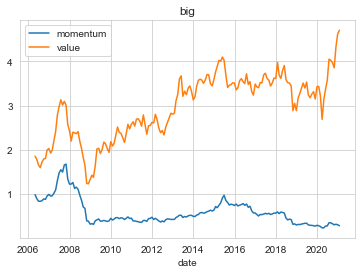

In [28]:
# 대형주 momentum, valeu 비교 (대형주는 quality 넉넉하게 잡는게 수익률 좋음)
bm_cr = ((m_ret * bm_cap_weight.shift(1)).sum(axis = 1) + 1).cumprod()[75:]
bv_cr = ((m_ret * bv_cap_weight.shift(1)).sum(axis = 1) + 1).cumprod()[75:]

h, l, mdd = MDD(bm_cr.values)
print(f'momentum: high - {bm_cr.index[h]}, low - {bm_cr.index[l]}, mdd - {round(mdd, 4)}')
h, l, mdd = MDD(bv_cr.values)
print(f'value:    high - {bv_cr.index[h]}, low - {bv_cr.index[l]}, mdd - {round(mdd, 4)}')

sns.set_style('whitegrid')
sns.lineplot(bm_cr.index, bm_cr, label='momentum')
sns.lineplot(bv_cr.index, bv_cr, label='value')
plt.title('big')
plt.show()

momentum: high - 2008-05-31 00:00:00, low - 2008-11-30 00:00:00, mdd - 0.6477
value:    high - 2008-05-31 00:00:00, low - 2008-10-31 00:00:00, mdd - 0.4563


/Users/daeyoung/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/daeyoung/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


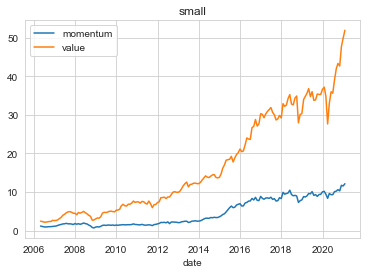

In [29]:
# 소형주 momentum, value 비교
sm_cr = ((m_ret * sm_cap_weight.shift(1)).sum(axis = 1) + 1).cumprod()[75:]
sv_cr = ((m_ret * sv_cap_weight.shift(1)).sum(axis = 1) + 1).cumprod()[75:]

h, l, mdd = MDD(sm_cr.values)
print(f'momentum: high - {sm_cr.index[h]}, low - {sm_cr.index[l]}, mdd - {round(mdd, 4)}')
h, l, mdd = MDD(sv_cr.values)
print(f'value:    high - {sv_cr.index[h]}, low - {sv_cr.index[l]}, mdd - {round(mdd, 4)}')

sns.set_style('whitegrid')
sns.lineplot(sm_cr.index, sm_cr, label='momentum')
sns.lineplot(sv_cr.index, sv_cr, label='value')
plt.title('small')
plt.show()

In [30]:
# 소형주 1월효과 존재하는지
print(sv_cr.index[9])
print(f'1월: {round(sv_cr[9::12].mean(), 4)}, 전체: {round(sv_cr.mean(), 4)}')

2007-01-31 00:00:00
1월: 18.2915, 전체: 16.6819


big momentum: high - 2007-10-31 00:00:00, low - 2020-03-31 00:00:00, mdd - 0.8599
small value:  high - 2008-05-31 00:00:00, low - 2008-10-31 00:00:00, mdd - 0.4563


/Users/daeyoung/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/daeyoung/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/daeyoung/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

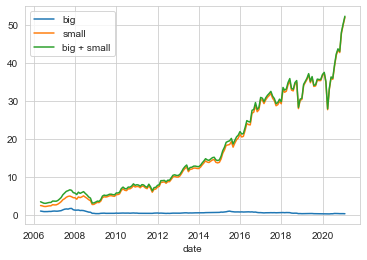

In [31]:
# 대형주 momentum, 소형주 value,  공통 quality
h, l, mdd = MDD(bm_cr.values)
print(f'big momentum: high - {bm_cr.index[h]}, low - {bm_cr.index[l]}, mdd - {round(mdd, 4)}')
h, l, mdd = MDD(sv_cr.values)
print(f'small value:  high - {sv_cr.index[h]}, low - {sv_cr.index[l]}, mdd - {round(mdd, 4)}')

sns.set_style('whitegrid')
sns.lineplot(bm_cr.index, bm_cr, label='big')
sns.lineplot(sv_cr.index, sv_cr, label='small')
sns.lineplot(bm_cr.index, bm_cr + sv_cr, label='big + small')
plt.show()

## 대형주와 소형주 (각각 상하위 100개 씩) 
## momentum과 value factor 효과

momentum: high - 2007-10-31 00:00:00, low - 2019-08-31 00:00:00, mdd - 0.8964
value:    high - 2007-10-31 00:00:00, low - 2008-11-30 00:00:00, mdd - 0.6276
momentum (hit): total - 0.4719, recent - 6
value (hit): total - 0.5337, recent - 8


/Users/daeyoung/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/daeyoung/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


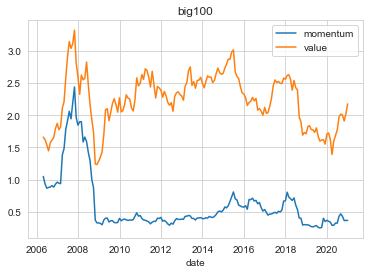

In [32]:
# 시총 상위 100개 기업에 대한 momentum과 value factor 누적 수익률 
b100_mask = m_cap.rank(axis=1, ascending=False) <= 100
bq100_mask = total_qz[b100_mask].rank(axis=1, pct=True) < 0.8
bm100_mask = momentum[momentum[bq100_mask] > 0].rank(axis=1, pct=True, ascending=False) < 0.3
bv100_mask = total_vz[bq100_mask].rank(axis=1, pct=True) < 0.3
bm100_cap_weight = (m_cap[bm100_mask].T / m_cap[bm100_mask].sum(axis=1)).T
bv100_cap_weight = (m_cap[bv100_mask].T / m_cap[bv100_mask].sum(axis=1)).T

bm100_r = (m_ret * bm100_cap_weight.shift(1)).sum(axis = 1)
bm100_cr = (bm100_r + 1).cumprod()[75:-1]
bv100_r = (m_ret * bv100_cap_weight.shift(1)).sum(axis = 1)
bv100_cr = (bv100_r + 1).cumprod()[75:-1]

# 동일비중
# bm100_cr = (m_ret[bm100_mask.shift(1)].mean(axis=1)+1).fillna(1).cumprod()[75:]
# bv100_cr = (m_ret[bv100_mask.shift(1)].mean(axis=1)+1).fillna(1).cumprod()[75:]

h, l, mdd = MDD(bm100_cr.values)
print(f'momentum: high - {bm100_cr.index[h]}, low - {bm100_cr.index[l]}, mdd - {round(mdd, 4)}')
h, l, mdd = MDD(bv100_cr.values)
print(f'value:    high - {bv100_cr.index[h]}, low - {bv100_cr.index[l]}, mdd - {round(mdd, 4)}')

t, r = hit_ratio(bm100_r.values[75:], 12, False)
print(f'momentum (hit): total - {t}, recent - {r}')
t, r = hit_ratio(bv100_r.values[75:], 12, False)
print(f'value (hit): total - {t}, recent - {r}')

sns.set_style('whitegrid')
sns.lineplot(bm100_cr.index, bm100_cr, label='momentum')
sns.lineplot(bv100_cr.index, bv100_cr, label='value')
plt.title('big100')
plt.show()

In [33]:
vol_rank = m_pm.rolling(48).std().rank(axis=1, pct=1)

value:    high - 2019-04-30 00:00:00, low - 2020-03-31 00:00:00, mdd - 0.4302
value (~2020.02): high - 2008-06-30 00:00:00, low - 2008-10-31 00:00:00, mdd - 0.3767
value (hit): total - 0.6798, recent - 9


/Users/daeyoung/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


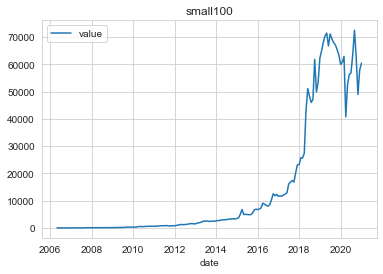

In [34]:
# 시총 하위 200개 기업에 대한 momentum과 value factor 누적 수익률
# 동일 비중보다 시총가중의 수익률이 훨신 높음
s100_mask = m_cap.rank(axis=1, pct=True) < 0.1
sq100_mask = total_qz[s100_mask].rank(axis=1, pct=True) < 0.4
sv100_mask = total_vz[sq100_mask].rank(axis=1, pct=True) < 0.5
sv100_mask = momentum[sv100_mask].rank(axis=1, pct=True, ascending=True) < 0.5
# sv100_mask = vol_rank[sv100_mask] < 0.5

sm100_mask = momentum[momentum[sq100_mask] > 0].rank(axis=1, pct=True, ascending=False) < 0.4


sm100_cap_weight = (m_cap[sm100_mask].T / m_cap[sm100_mask].sum(axis=1)).T
sv100_cap_weight = (m_cap[sv100_mask].T / m_cap[sv100_mask].sum(axis=1)).T

# sm100_r = (m_ret * sm100_cap_weight.shift(1)).sum(axis = 1)
# sv100_r = (m_ret * sv100_cap_weight.shift(1)).sum(axis = 1)

# # 동일비중
sm100_r = m_ret[sm100_mask.shift(1)].mean(axis=1).fillna(0)
sv100_r = m_ret[sv100_mask.shift(1)].mean(axis=1).fillna(0)

sm100_cr = (sm100_r + 1).cumprod()[75:-1]
sv100_cr = (sv100_r + 1).cumprod()[75:-1]

h, l, mdd = MDD(sv100_cr.values)
print(f'value:    high - {sv100_cr.index[h]}, low - {sv100_cr.index[l]}, mdd - {round(mdd, 4)}')
h, l, mdd = MDD(sv100_cr[:-21].values)
print(f'value (~2020.02): high - {sv100_cr[:-10].index[h]}, low - {sv100_cr[:-10].index[l]}, mdd - {round(mdd, 4)}')

t, r = hit_ratio(sv100_r.values[75:], 12, False)
print(f'value (hit): total - {t}, recent - {r}')

sns.set_style('whitegrid')
sns.lineplot(sv100_cr.index, sv100_cr, label='value')
plt.title('small100')
plt.show()

In [35]:
momentum2 = (m_pm / m_pm.shift(6) - m_pm / m_pm.shift(1))

value:    high - 2019-12-31 00:00:00, low - 2020-10-31 00:00:00, mdd - 0.5091
value:    high - 2007-09-30 00:00:00, low - 2008-10-31 00:00:00, mdd - 0.4859
value (hit): total - 0.4944, recent - 3


/Users/daeyoung/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


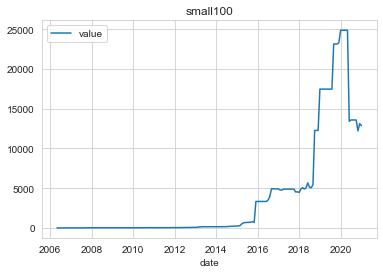

In [36]:
# 최근 주가로 계산한 value factor
s100_mask = (m_cap.rank(axis=1, pct=True) < 0.1)# & (m_cap.rank(axis=1) >= 200)
sq100_mask = total_qz[s100_mask].rank(axis=1, pct=True) < 0.2
sv100_mask_r = total_vzr[sq100_mask].rank(axis=1, pct=True) < 0.4
sv100_mask_r = vol_rank[sv100_mask_r] < 0.3
sv100_cap_weight_r = (m_cap[sv100_mask_r].T / m_cap[sv100_mask_r].sum(axis=1)).T
# sv100_r_r = (m_ret * sv100_cap_weight_r.shift(1)).sum(axis = 1)

# 동일비중
sv100_r_r = m_ret[sv100_mask_r.shift(1)].mean(axis=1).fillna(0)

sv100_cr_r = (sv100_r_r + 1).fillna(1).cumprod()[75:-1]             

h, l, mdd = MDD(sv100_cr_r.values)
print(f'value:    high - {sv100_cr_r.index[h]}, low - {sv100_cr_r.index[l]}, mdd - {round(mdd, 4)}')
h, l, mdd = MDD(sv100_cr_r[:-11].values)
print(f'value:    high - {sv100_cr_r.index[h]}, low - {sv100_cr_r.index[l]}, mdd - {round(mdd, 4)}')

t, r = hit_ratio(sv100_r_r.values[75:], 12, False)
print(f'value (hit): total - {t}, recent - {r}')

sns.set_style('whitegrid')
#모멘텀 너무 괴랄하게 나와서 제외(특이 케이스같음..)
sns.lineplot(sv100_cr_r.index, sv100_cr_r, label='value')
plt.title('small100')
plt.show()

In [123]:
# 소형주 1월효과 존재하는지
print(sv100_cr.index[9])
print(f'1월: {round(sv100_cr[9::12].mean(), 4)}, 전체: {round(sv100_cr.mean(), 4)}')

2007-01-31 00:00:00
1월: 51.771, 전체: 43.0719


In [297]:
# 5% 이상 떨어지는 경우 손절하고 해당 월에는 다시 투자하지 않음 (익절라인 잡지않는 것이 이득)
# 현재가로 변환해서 투자하는게 더 좋음 (수익률의 변동성이 더 낮음)
m_ret_t = m_ret.copy()
out = 0.7
rein = 0.6
mask = sv100_mask
pm_group =  pm.groupby('date')
for i in range(75, len(mask.index)-1):
    portfolio = mask.iloc[i][mask.iloc[i]==True].index
    m_pm_info =pm_group.get_group(mask.index[i+1])[portfolio]
    stop_loss_mask = (m_pm_info < (m_pm_info.iloc[0] * out))
    stop_loss_idx = stop_loss_mask.sum()[stop_loss_mask.sum() > 0].index
    if len(stop_loss_idx) > 0:
        m_ret_t.iloc[i][stop_loss_idx] = (m_pm_info[stop_loss_mask].bfill() / m_pm_info.iloc[0] - 1).iloc[0].dropna()
    
#         for j in stop_loss_idx:
#             rein_mask = m_pm_info[stop_loss_mask][j].bfill().dropna()[1:] < (m_pm_info[j][0] * rein)
#             if rein_mask.sum() > 0:
#                 rein_r = m_pm_info[j][-1] - m_pm_info[stop_loss_mask][j].bfill().dropna()[1:][rein_mask].ffill()[0]
#                 m_ret_t[j][i] = (m_ret_t[j][i] * m_pm_info[j].iloc[0] + rein_r) / m_pm_info[j].iloc[0]

value:    high - 2019-04-30 00:00:00, low - 2020-03-31 00:00:00, mdd - 0.5408
value (hit): total - 0.6742, recent - 8


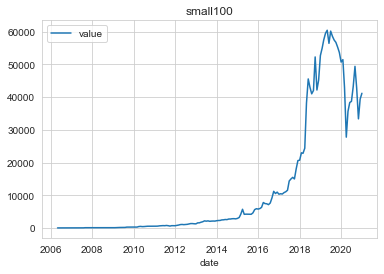

In [298]:
sv100_r10 = m_ret_t[mask.shift(1)].mean(axis=1).fillna(0)
sv100_cr10 = (sv100_r10 + 1).cumprod()[75:-1]

h, l, mdd = MDD(sv100_cr10.values)
print(f'value:    high - {sv100_cr10.index[h]}, low - {sv100_cr10.index[l]}, mdd - {round(mdd, 4)}')
t, r = hit_ratio(sv100_r10.values[75:], 12, False)
print(f'value (hit): total - {t}, recent - {r}')

sns.set_style('whitegrid')
sns.lineplot(sv100_cr10.index, sv100_cr10, label='value')
plt.title('small100')
plt.show()

In [19]:
m_ret_t = m_ret.copy()
cnt=0
for i in range(75, len(bm100_mask.index)):
    portfolio = bm100_mask.iloc[i][bm100_mask.iloc[i]==True].index
    m_pm_info = pm.groupby('date').get_group(bm100_mask.index[i])[portfolio]
    stop_loss = (m_pm_info < (m_pm_info.iloc[0] * 0.9)).sum()
    if len(stop_loss[stop_loss > 0].index) > 0:
        m_ret_t.iloc[i][stop_loss[stop_loss > 0].index] = -0.1

value:    high - 2007-10-31 00:00:00, low - 2020-03-31 00:00:00, mdd - 0.6952
value (hit): total - 0.4916, recent - 6


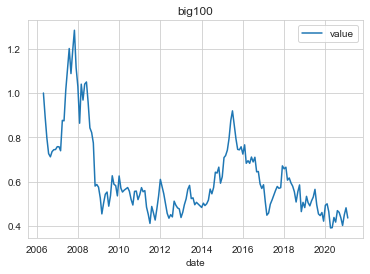

In [20]:
bm100_cap_weight10 = (m_cap[bm100_mask].T / m_cap[bm100_mask].sum(axis=1)).T
bm100_r10 = (m_ret_t * bm100_cap_weight10.shift(1)).sum(axis = 1)
bm100_cr10 = (bm100_r10 + 1).cumprod()[75:-1]

h, l, mdd = MDD(bm100_cr10.values)
print(f'value:    high - {bm100_cr10.index[h]}, low - {bm100_cr10.index[l]}, mdd - {round(mdd, 4)}')
t, r = hit_ratio(bm100_r10.values[75:], 12, False)
print(f'value (hit): total - {t}, recent - {r}')

sns.set_style('whitegrid')
sns.lineplot(bm100_cr10.index, bm100_cr10, label='value')
plt.title('big100')
plt.show()

## 대형주 momentum + 소형주 value (효과 극대화)<br>
### 대형주 - 시가총액 상위 200개 종목, quality 상위 60%, momentum 상위 10%
### 소형주 - 시가총액 하위 100개 종목, quality 상위 20%, value 상위 30%
##### (간단한 서치로 수익률, MDD 좋은 것으로 정함)
##### (합쳐서 10개 종목이 넘지 않게함)

In [128]:
bm_idx = bm100_mask.iloc[-1][bm100_mask.iloc[-1]==True].index
sv_idx = sv100_mask.iloc[-1][sv100_mask.iloc[-1]==True].index
sv_idx_r = sv100_mask_r.iloc[-1][sv100_mask_r.iloc[-1]==True].index
bs_idx = list(bm_idx) + list(sv_idx)
bs_idx_r = list(bm_idx) + list(sv_idx_r)

In [129]:
# 변동성 비교
bm_cov = pm[bm_idx].cov()
bm_weight = bm100_cap_weight.iloc[-1].dropna()
print(np.sqrt(np.dot(bm_weight.T.values, np.dot(bm_cov.values, bm_weight.values))))

sv_cov = pm[sv_idx].cov()
# 동일비중
sv_weight = np.ones(len(sv_idx)) / len(sv_idx)
# 시가총액가중
# sv_weight = sv100_cap_weight.iloc[-1].dropna()
print(np.sqrt(np.dot(sv_weight, np.dot(sv_cov.values, sv_weight))))

sv_cov_r = pm[sv_idx_r].cov()
sv_weight_r = np.ones(len(sv_idx_r)) / len(sv_idx_r)
print(np.sqrt(np.dot(sv_weight_r, np.dot(sv_cov_r.values, sv_weight_r))))

big = 0.5
bs_cov = pm[bs_idx].cov()
bs_weight = np.append(bm_weight * big, sv_weight * (1 - big))
print(np.sqrt(np.dot(bs_weight, np.dot(bs_cov.values, bs_weight))))

bs_cov_r = pm[bs_idx_r].cov()
bs_weight_r = np.append(bm_weight * big, sv_weight_r * (1 - big))
print(np.sqrt(np.dot(bs_weight_r, np.dot(bs_cov_r.values, bs_weight_r))))

25999.729857204875
588.565628033737
495.93166360263297
12963.685312776526
12967.755755411688


0.3337138423908663


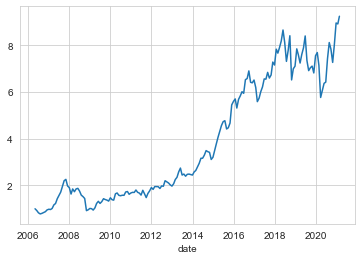

In [130]:
# 효과를 극대화한 대형주 momentum, 소형주 value 누적수익률
bm100_cap_weight_f0 = bm100_cap_weight.fillna(0)

# 동일비중
sv_t = sv100_mask.copy().astype(int)
sv_t['temp'] = sv100_mask.sum(axis=1)
sv_t = sv_t.replace(1, 0).replace(0, np.nan).bfill(axis=1)
del sv_t['temp']
sv100_cap_weight_f0 = (sv100_mask.astype(int) / sv_t)

bs_cap_weight = (bm100_cap_weight_f0 * big + sv100_cap_weight_f0 * (1- big))
bs_cr = ((m_ret * bs_cap_weight.shift(1)).sum(axis=1) + 1).cumprod()[75:]
print(MDD(bs_cr)[2])
sns.lineplot(bs_cr.index, bs_cr)
plt.show()

0.3088925317231583


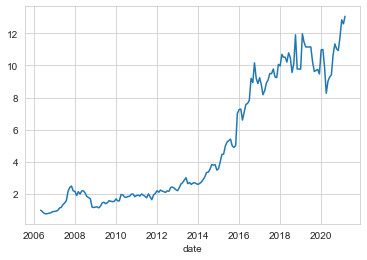

In [131]:
sv_tr = sv100_mask_r.copy().astype(int)
sv_tr['temp'] = sv100_mask_r.sum(axis=1)
sv_tr = sv_tr.replace(1, 0).replace(0, np.nan).bfill(axis=1)
del sv_tr['temp']
sv100_cap_weight_f0_r = (sv100_mask_r.astype(int) / sv_tr)

bs_cap_weight_r = (bm100_cap_weight_f0 * big + sv100_cap_weight_f0_r * (1- big))
bs_cr_r = ((m_ret * bs_cap_weight_r.shift(1)).sum(axis=1) + 1).cumprod()[75:]
print(MDD(bs_cr_r)[2])
sns.lineplot(bs_cr_r.index, bs_cr_r)
plt.show()

In [132]:
# 샤프비율 비교
bm_mr = (m_ret * bm100_cap_weight_f0.shift(1)).sum(axis=1)
sv_mr = (m_ret * sv100_cap_weight_f0.shift(1)).sum(axis=1)
sv_mr_r = (m_ret * sv100_cap_weight_f0_r.shift(1)).sum(axis=1)
bs_mr = (m_ret * bs_cap_weight.shift(1)).sum(axis=1)
bs_mr_r = (m_ret * bs_cap_weight_r.shift(1)).sum(axis=1)
print(bm_mr.mean() / bm_mr.std())
print(sv_mr.mean() / sv_mr.std())
print(sv_mr_r.mean() / sv_mr_r.std())
print(bs_mr.mean() / bs_mr.std())
print(bs_mr_r.mean() / bs_mr_r.std())

-0.029143931501308177
0.33394334057451575
0.28493335783700857
0.1707545591441733
0.17645012450759012


In [133]:
pm[bs_idx].corr().loc[bm_idx][sv_idx]

,A208710,A900280,A090150,A007530,A012620,A900300,A091440,A323230,A060380,A032280,A900110,A098660,A900080
A091990,-0.112155,-0.167304,0.294146,0.483331,0.134825,-0.317258,0.421557,-0.128471,0.097793,-0.059207,-0.025730,-0.297516,-0.257333
A068760,-0.446096,-0.556636,0.112509,0.147469,0.346646,-0.631797,0.442699,-0.103119,0.201148,0.056961,-0.599909,0.068616,-0.589408
A096530,-0.395268,-0.471439,0.137665,-0.002969,0.033741,-0.629837,0.212515,-0.251898,-0.023708,-0.104075,-0.352317,0.019459,-0.445090
A196170,-0.496003,-0.589594,0.063398,-0.262036,-0.394720,-0.730154,0.004915,-0.256752,-0.263323,-0.474222,-0.448330,-0.266768,-0.632087
A064760,-0.384704,-0.674697,0.165455,0.398525,0.594023,-0.736300,0.619019,-0.222322,0.416818,0.305679,-0.727511,0.261072,-0.663490
A141080,-0.455440,-0.625683,0.236014,-0.034312,-0.038645,-0.715765,0.298952,-0.164337,0.252289,-0.272984,-0.678822,0.031407,-0.732478
A069080,-0.084305,-0.225701,0.116669,-0.057967,0.091962,-0.292590,0.670747,-0.194261,-0.162957,0.089430,-0.382497,0.464808,-0.420772
A144510,-0.354570,-0.460132,-0.133385,-0.144456,-0.101698,-0.463866,0.112819,-0.121176,-0.113977,-0.306782,-0.417285,-0.453304,-0.459407
A025900,-0.080890,-0.246836,0.319205,0.723175,0.779460,-0.386068,0.749243,-0.186735,0.600933,0.142990,-0.500216,0.536598,-0.502835
A048410,-0.505847,-0.625842,0.629429,-0.486044,-0.535136,-0.686881,0.196775,0.282233,-0.432719,-0.271992,-0.331365,0.133009,-0.114744


In [134]:
seed = 20
bs_invest = bs_weight*seed
code_df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download', header=0)[0][['회사명', '종목코드']]
for i in range(len(bs_idx)):
    print(code_df.query(f'종목코드=={int(bs_idx[i][1:])}').values[0][0], bs_idx[i][1:], round(bs_invest[i], 4))

셀트리온헬스케어 091990 4.3345
셀트리온제약 068760 1.2219
씨젠 096530 0.8836
알테오젠 196170 0.7604
티씨케이 064760 0.3385
레고켐바이오 141080 0.2638
웹젠 069080 0.272
녹십자랩셀 144510 0.2276
동화기업 025900 0.2427
현대바이오 048410 0.2086
상아프론테크 089980 0.1818
씨아이에스 222080 0.1777
에이스테크 088800 0.1787
바이넥스 053030 0.1671
유바이오로직스 206650 0.1384
대주전자재료 078600 0.1365
티에스이 131290 0.1325
파크시스템스 140860 0.1337
바이오로그디바이스 208710 0.7692
골든센츄리 900280 0.7692
광진윈텍 090150 0.7692
영신금속 007530 0.7692
원일특강 012620 0.7692
오가닉티코스메틱 900300 0.7692
텔레필드 091440 0.7692
엠에프엠코리아 323230 0.7692
동양에스텍 060380 0.7692
삼일 032280 0.7692
이스트아시아홀딩스 900110 0.7692
에스티오 098660 0.7692
에스앤씨엔진그룹 900080 0.7692


In [135]:
seed = 20
bs_invest_r = bs_weight_r*seed
for i in range(len(bs_idx_r)):
    print(code_df.query(f'종목코드=={int(bs_idx_r[i][1:])}').values[0][0], bs_idx_r[i][1:], round(bs_invest_r[i], 4))

셀트리온헬스케어 091990 4.3345
셀트리온제약 068760 1.2219
씨젠 096530 0.8836
알테오젠 196170 0.7604
티씨케이 064760 0.3385
레고켐바이오 141080 0.2638
웹젠 069080 0.272
녹십자랩셀 144510 0.2276
동화기업 025900 0.2427
현대바이오 048410 0.2086
상아프론테크 089980 0.1818
씨아이에스 222080 0.1777
에이스테크 088800 0.1787
바이넥스 053030 0.1671
유바이오로직스 206650 0.1384
대주전자재료 078600 0.1365
티에스이 131290 0.1325
파크시스템스 140860 0.1337
골든센츄리 900280 2.0
영신금속 007530 2.0
동양에스텍 060380 2.0
이스트아시아홀딩스 900110 2.0
에스티오 098660 2.0


In [320]:
sv_idx = list(sv100_mask.iloc[-1][sv100_mask.iloc[-1]==True].index)
code_df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download', header=0)[0][['회사명', '종목코드']]
for j in range(len(sv_idx)):
    print(code_df.query(f'종목코드=={int(sv_idx[j][1:])}').values[0][0], sv_idx[j][1:])
print()

텔레필드 091440
이스트아시아홀딩스 900110
에스티오 098660



In [138]:
pm[sv_idx].iloc[-1]

A900280     300.0
A007530    3550.0
A060380    3570.0
A900110     201.0
A098660    2370.0
Name: 2021-02-28 00:00:00, dtype: float64

## 시가총액이 낮은 기업이 상장폐지될 확률 높다고 생각<br>
#### 시총이 낮으면 상폐가 많이 됐지만 quality와 value로 필터링한 종목에는 없음!

In [31]:
# 전체 상폐된 기업과 폐지된 월
delist_total = (m_ret==-1)
delist_temp = delist_total[delist_total==True]
for i in range(0, len(m_pm)):
    zero_r = set(delist_temp.iloc[i].dropna().index)
    if zero_r:
        print(m_pm.index[i], zero_r)

2000-02-29 00:00:00 {'A003380', 'A006000', 'A011890', 'A008920'}
2000-05-31 00:00:00 {'A007840'}
2000-07-31 00:00:00 {'A007090', 'A022770', 'A027610', 'A017620', 'A012010', 'A010810', 'A017740', 'A018720', 'A022510', 'A025150', 'A003430', 'A013310', 'A014090', 'A013320', 'A013850'}
2000-08-31 00:00:00 {'A026240', 'A006300'}
2000-12-31 00:00:00 {'A015060'}
2001-01-31 00:00:00 {'A022060'}
2001-06-30 00:00:00 {'A030700', 'A017090', 'A033300'}
2001-08-31 00:00:00 {'A022870'}
2001-09-30 00:00:00 {'A025080'}
2001-10-31 00:00:00 {'A023780'}
2002-04-30 00:00:00 {'A039500'}
2002-05-31 00:00:00 {'A033070', 'A013630'}
2002-06-30 00:00:00 {'A027560'}
2002-07-31 00:00:00 {'A044570'}
2002-08-31 00:00:00 {'A022780', 'A037740', 'A021930'}
2002-11-30 00:00:00 {'A024080', 'A020490', 'A040780', 'A021740'}
2002-12-31 00:00:00 {'A042470', 'A017210', 'A033040', 'A049790'}
2003-01-31 00:00:00 {'A022220', 'A030970'}
2003-04-30 00:00:00 {'A037280'}
2003-05-31 00:00:00 {'A034970', 'A060840', 'A032780', 'A034980

In [32]:
# sv100 중 상폐된 기업과 폐지된 월: 없음!
for i in range(0, len(sv100_mask)):
    zero_r = set(delist_temp.iloc[i].dropna().index)
    sv100_index = set(sv100_mask[sv100_mask==True].iloc[i].dropna().index)
    if sv100_index & zero_r:
        print(sv100_mask.index[i], sv100_index & zero_r)

In [171]:
# bm100 중 상폐된 기업과 폐지된 월: 없음!
for i in range(0, len(bm100_mask)):
    zero_r = set(delist_temp.iloc[i].dropna().index)
    bm100_index = set(bm100_mask[sv100_mask==True].iloc[i].dropna().index)
    if bm100_index & zero_r:
        print(bm100_mask.index[i], bm100_index & zero_r)

In [48]:
# 소형주의 수익률이 좋았어서 소형주 비율을 알아보기 위해 함수 정의
def cap_quantile_check(true_false_df, m_cap, axis=1, pct=1, ascending=True, mean=False):
    cap_quantile = m_cap.rank(axis=axis, pct=pct, ascending=ascending)[true_false_df] // 0.2
    p = pd.Series({0.0:0, 1.0:0, 2.0:0, 3.0:0, 4.0:0})
    for i in range(0, len(m_cap)):
        temp = cap_quantile.iloc[i].dropna().value_counts().sort_index().astype(int)
        p[temp.index] += temp
    if mean:
        p /= len(m_cap)
    print(f'p1: {p[0]}\np2: {p[1]}\np3: {p[2]}\np4: {p[3]}\np5: {p[4]}')
    print()

In [49]:
# 시총기준으로 5개 분위수를 나눈 뒤 상장폐지된 기업 수 비교
# 상장폐지된 달의 시총은 nan이기 때문에 m_cap을 1 shift해서 전 달 시총 사용
cap_quantile_check(delist_total, m_cap.shift(1), ascending=False)

p1: 27
p2: 20
p3: 10
p4: 12
p5: 463



## 결과: 소형주 상장폐지가 많았다
## value와 quality로 필터링한 뒤에는 상장폐지된 종목이 없다.

## 다른 전략 : quality 상위 40% -> value 상위 20%

In [50]:
# quality factor에서 수익률이 좋았던 1,2 분위를 대상(40%)으로 시총기준 분포 확인 (전체 달의 평균)
quality_40 = total_qz.rank(axis=1, pct=1) < 0.4
cap_quantile_check(quality_40, m_cap, ascending=False, mean=True)

# value factor로 필터링한 뒤 시총기준 분포확인
value_20 = total_vz[quality_40].rank(axis=1, pct=1) < 0.6
cap_quantile_check(value_20, m_cap, mean=True)

p1: 71.62845849802372
p2: 61.984189723320156
p3: 54.015810276679844
p4: 50.537549407114625
p5: 35.284584980237156

p1: 18.68774703557312
p2: 29.26482213438735
p3: 28.778656126482215
p4: 29.217391304347824
p5: 26.818181818181817



In [ ]:
# 누적수익률
(m_ret[value_20].mean(axis=1).fillna(0)+1).cumprod()

In [ ]:
value_40 = total_vz.rank(axis=1, pct=1) < 0.6
cap_quantile_check(value_40, m_cap, ascending=True, mean=True)

# value factor로 필터링한 뒤 시총기준 분포확인
quality_20 = total_qz[quality_40].rank(axis=1, pct=1) < 0.3
cap_quantile_check(quality_20, m_cap, ascending=False, mean=True)

In [ ]:
# 누적수익률
(m_ret[quality_20].mean(axis=1).fillna(0)+1).cumprod()

## 결과: 잘 안나옴!

In [49]:
df = pd.read_csv("../../data/kospi/kospi.csv", index_col='date', parse_dates=True, thousands=',')
df.index = df.index + pd.tseries.offsets.MonthEnd(0)
df = df.groupby('date').last()
temp = (df['코스피'] / df['코스피'].shift(1)).cumprod()

In [56]:
MDD(df['코스피'])

(93, 109, 0.48517810010412377)

In [57]:
MDD(df['코스피 200'])

(93, 109, 0.46981798632977506)